In [1]:
import numpy as np
import pandas as pd
import cvxpy as cp
import mosek
import matplotlib.pyplot as plt
import scipy.stats
import phi_divergence as phi
from time import process_time


In [2]:
def toymodel(Z_arr):
    x = cp.Variable(2, nonneg = True)
    constraints = [Z_arr @ x <= 1, x[0] <= x[1]-1, x<=10]
    obj = cp.Maximize(cp.sum(x))
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(x.value, prob.value)

def toymodel_true(beta):
    x = cp.Variable(2, nonneg = True)
    constraints = [x[0] <= x[1]-1, x<=10, (1-2*beta)*x[1] + 1 >= 0]
    obj = cp.Maximize(cp.sum(x))
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(x.value, prob.value)

def lowbound(p,r, par, phi_div):
    q = cp.Variable(2, nonneg = True)
    constraints = [cp.sum(q) == 1]
    constraints = phi_div(p,q,r,par,constraints)
    obj = cp.Minimize(q[0])
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(prob.value)

In [3]:
par = 1
phi_div = phi.mod_chi2_cut
n = 1000
phi_dot = 1
alpha = 0.1
r = phi_dot/(2*n)*scipy.stats.chi2.ppf(1-alpha, 1)

In [4]:
np.random.seed(1)
data = np.random.uniform(-1,1,size = (n,2))
Z_arr = np.array([data[0]])
beta = 0.95
delta = 1/n

In [6]:
lb = -np.inf                      
while beta > lb:
    [x, obj] = toymodel(Z_arr)
    constr = data.dot(x)
    p = np.array([len(constr[constr<=1])/n,len(constr[constr>1])/n])
    lb = lowbound(p,r, par, phi_div)
    gap = np.ceil(n*(beta-lb)).astype(int)
    if gap > 0:
        vio_sort = np.sort(constr[constr>1])    #the violations are ranked here
        vio_value = vio_sort[gap-1]
        ind = np.where(constr == vio_value)[0][0]   # the n*(beta-lb)-th scenario is added
        Z_arr = np.append(Z_arr, np.array([data[ind]]),axis = 0)
print('true prob', 1/2+1/(2*x[1]))
print(obj)
print(lb)
print(len(Z_arr))

true prob 0.958669367420551
1.1802197204137297
0.9518734130797427
3


In [24]:
np.random.seed(1)
data = np.random.uniform(-1,1,size = (n,2))
Z_arr = np.array([data[0]])
beta = 0.8
delta = 1/n

In [23]:
lb = -np.inf
while beta > lb:
    [x, obj] = toymodel(Z_arr)
    constr = data.dot(x)
    p = np.array([len(constr[constr<=1])/n,len(constr[constr>1])/n])
    lb = lowbound(p,r, par, phi_div)
    if len(constr[constr>1])!= 0:
        vio_min = np.min(constr[constr>1])        # the least violated scenario is added
        ind = np.where(constr == vio_min)[0][0]
        Z_arr = np.append(Z_arr, np.array([data[ind]]),axis = 0)
print(obj)
print(lb)
print('true prob', 1/2+1/(2*x[1]))
print(len(Z_arr))

1.1668172993471453
0.9506223207253122
true prob 0.9615063763305174
201


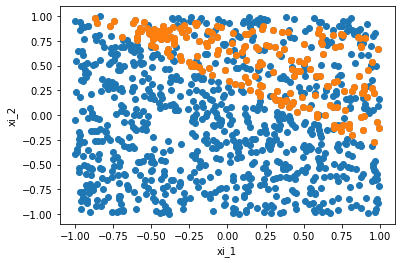

In [51]:
plt.plot(data[:,0],data[:,1],'o')
plt.plot(Z_arr[:,0],Z_arr[:,1],'o')
plt.xlabel('xi_1')
plt.ylabel('xi_2')
plt.savefig('N1000alpha05beta095', format = 'eps')

In [69]:
[x_true, obj_true] = toymodel_true(beta)
constr = data.dot(x_true)
p = np.array([len(constr[constr<=1])/n,len(constr[constr>1])/n])
lb = lowbound(x_true,p,r, par, phi_div)
print(p)
print(lb)
print(obj_true)

[0.834 0.166]
0.8176931077100779
1.8571428571428572


In [5]:
def opt_set(data, F, M):
    N = len(data)
    x = cp.Variable(2, nonneg = True)
    y = cp.Variable(N, boolean = True)
    constraints = [x[0]-x[1] <= -1, x <= 10, data @ x <= 1 + (1-y)*M, cp.sum(y) >= F]
    obj = cp.Maximize(cp.sum(x))
    prob = cp.Problem(obj,constraints)
    prob.solve(solver=cp.MOSEK)
    return(x.value, y.value, prob.value)
    

In [6]:
M = 1000
p_hat = 0.81431
F = np.ceil(p_hat * n)
x_val, y_val, prob_val = opt_set(data, F, M)
print(x_val, np.sum(y_val), prob_val)

[0.52970761 1.52970761] 815.0 2.0594152186808845


In [7]:
n

1000

[array([-0.16595599,  0.44064899]),
 array([-0.99977125, -0.39533485]),
 array([-0.70648822, -0.81532281]),
 array([-0.62747958, -0.30887855]),
 array([-0.20646505,  0.07763347]),
 array([-0.16161097,  0.370439  ]),
 array([-0.5910955 ,  0.75623487]),
 array([-0.94522481,  0.34093502]),
 array([-0.1653904 ,  0.11737966]),
 array([-0.71922612, -0.60379702]),
 array([-0.37315164,  0.38464523]),
 array([0.7527783 , 0.78921333]),
 array([-0.82991158, -0.92189043]),
 array([-0.66033916,  0.75628501]),
 array([-0.80330633, -0.15778475]),
 array([0.91577906, 0.06633057]),
 array([ 0.38375423, -0.36896874]),
 array([0.37300186, 0.66925134]),
 array([-0.96342345,  0.50028863]),
 array([0.97772218, 0.49633131]),
 array([-0.43911202,  0.57855866]),
 array([-0.79354799, -0.10421295]),
 array([ 0.81719101, -0.4127717 ]),
 array([-0.42444932, -0.73994286]),
 array([-0.96126608,  0.35767107]),
 array([-0.57674377, -0.46890668]),
 array([-0.01685368, -0.89327491]),
 array([ 0.14823521, -0.70654285]),
